In [1]:
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from keras.callbacks import EarlyStopping
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import h5py
from pickle import dump
import random
from keras import backend as K

from Analysis_Helper import calculate_deltaR, change_cmap_bkg_to_white

import matplotlib.colors as colors
import matplotlib.cm as cm
cmap = 'rainbow'
cmap = change_cmap_bkg_to_white(cmap)

Using TensorFlow backend.


In [2]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10, 7)

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import os
# os.environ['PYTHONHASHSEED'] = '0'
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# # The below is necessary for starting Numpy generated random numbers
# # in a well-defined initial state.

# np.random.seed(42)

# # The below is necessary for starting core Python generated random numbers
# # in a well-defined state.

# random.seed(42)

# # Force TensorFlow to use single thread.
# # Multiple threads are a potential source of
# # non-reproducible results.
# # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=3, inter_op_parallelism_threads=3)

# # The below tf.set_random_seed() will make random number generation
# # in the TensorFlow backend have a well-defined initial state.
# # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

# tf.set_random_seed(42)

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [5]:
# # Use a fixed seed for random numbers generated by NumPy. (Keras typically uses NumPy to generate random values.)
# from numpy.random import seed
# seed(1)

# from tensorflow import set_random_seed
# set_random_seed(2)

# Neural Network Hyperparameters
Tuning of the neural network can be done by modifying these values

In [6]:
# Input hyperparameters
input_activation = 'selu'

# Hidden hyperparameters
nodes = [32,64,64,128,128,64,64,32]
hidden_activations = ['selu'] * len(nodes)
assert(len(nodes) == len(hidden_activations))
num_hidden = len(nodes)

# Output hyperparameters
output_activation = 'sigmoid'
output_nodes = 1

# Fitting hyperparameters
optimizer = 'nadam'
loss_function = 'binary_crossentropy'
num_epochs = 100
batch_size = 250

In [7]:
exp_success = 90
exp_fail = 100 - exp_success

In [8]:
# Saving options
folder = 'NN_models/MX700_MY400/' 
plots = folder + 'pt' + str(exp_success) + '-success_pt' + str(exp_fail) + '-fail/' # Change this for new runs

# Create folders if they don't already exist
if not os.path.exists(folder):
    os.makedirs(folder)
if not os.path.exists(plots):
    os.makedirs(plots)

filesave = plots

# Load Inputs
Inputs are loaded from .npz file. Later tests can compare file size for numpy arrays and Pandas dataframes.

In [9]:
# Load inputs
# inputs = np.load('nn_input_MX700_MY400_classifier.npz')
# inputs = np.load('nn_input_MX700_MY400_classifier_ptetacuts.npz')
inputs = np.load('/eos/user/s/srosenzw/SWAN_projects/sixB/Machine_Learning/Inputs/nn_input_MX700_MY400_classifier_allpairs.npz')

# Define parameters
X = inputs['x']
X_excess = inputs['extra_bkgd_x']
input_nodes = np.shape(X)[1]

# Define output
y = inputs['y']
y_excess = inputs['extra_bkgd_y']

# Used to compare score with dijet invariant mass
mjj = inputs['mjj'] # GeV
mjj_excess = inputs['extra_bkgd_mjj'] # GeV

In [10]:
true_Higgs_mask = (y == 1)

mbb_Higgs_pairs = mjj[true_Higgs_mask]
mjj_background = mjj[~true_Higgs_mask]

Perform a sanity check to make sure the inputs reconstruct the Higg mass.

In [11]:
# Determination of baseline (target) efficiency.

# Suppose the algorithm is learning the mass of the Higgs pairs.
# What kind of efficiency can we expect in the worst case scenario?

min_tol = np.min(mbb_Higgs_pairs)
max_tol = np.max(mbb_Higgs_pairs)

fake_mask = (mjj_background > min_tol) & (mjj_background < max_tol)

baseline_efficiency = (len(mbb_Higgs_pairs) + len(mjj_background[fake_mask])) / len(mjj) * 100

print("Baseline efficiency: {:.2f}%".format(baseline_efficiency))

Baseline efficiency: 50.25%


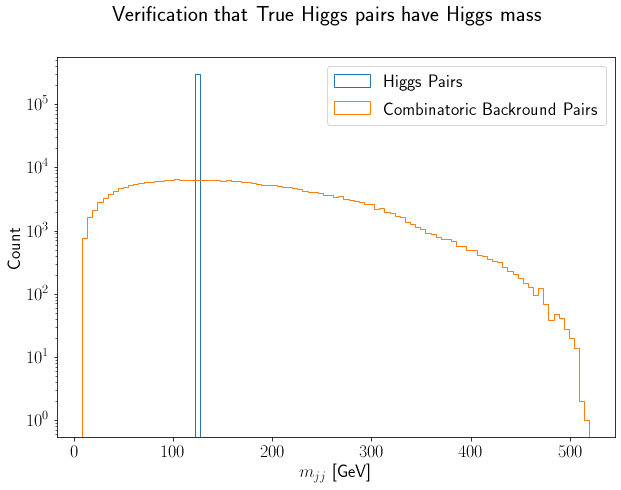

In [12]:
fig, ax = plt.subplots()
fig.suptitle("Verification that True Higgs pairs have Higgs mass")

bins = np.linspace(np.min(mjj),  np.max(mjj), 100)
n, bins, _ = ax.hist(mbb_Higgs_pairs, histtype='step', align='mid', bins=bins, label='Higgs Pairs')
ax.hist(mjj_background, histtype='step', align='mid', bins=bins, label='Combinatoric Backround Pairs')
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'$m_{jj}$ [GeV]')
ax.legend()

plt.show()

# Input Size Experiment

In [13]:
three_H_inputs = np.vstack((X[0::6,:], X[1::6,:], X[2::6,:]))
three_H_class = np.concatenate((y[0::6], y[1::6], y[2::6]))
three_H_mjj = np.concatenate((mjj[0::6], mjj[1::6], mjj[2::6]))

three_nonH_inputs = np.vstack((X[3::6,:], X[4::6,:], X[5::6,:]))
three_nonH_class = np.concatenate((y[3::6], y[4::6], y[5::6]))
three_nonH_mjj = np.concatenate((mjj[3::6], mjj[4::6], mjj[5::6]))

In [14]:
tot_inputs = np.floor(len(three_H_inputs)/0.9) # For input experiment. Do not change.

if exp_success > exp_fail:

    nfails = int(np.floor(tot_inputs*exp_fail/100))
    nsuccess = int(tot_inputs - nfails)

    assert(nsuccess <= len(three_H_inputs))

    isuccess = np.random.choice(len(three_H_inputs), size=nsuccess, replace=False)
    pool_nonH_x   = three_nonH_inputs[isuccess,:]
    pool_nonH_y   = three_nonH_class[isuccess]
    pool_nonH_mjj = three_nonH_mjj[isuccess]
    ifail = np.random.choice(len(pool_nonH_x), size=nfails, replace=False)

    x_H_input = three_H_inputs[isuccess,:]
    x_nonH_input = pool_nonH_x[ifail,:]
    y_H = three_H_class[isuccess]
    y_nonH = pool_nonH_y[ifail]
    mjj_H = three_H_mjj[isuccess]
    mjj_nonH = pool_nonH_mjj[ifail]
    
else:
    nsuccess = int(np.floor(tot_inputs*exp_success/100))
    nfails = int(tot_inputs - nsuccess)

    ifail = np.random.choice(len(three_nonH_inputs), size=nfails, replace=False)
    pool_H_x = three_H_inputs[ifail,:]
    pool_H_y = three_H_class[ifail]
    pool_H_mjj = three_H_mjj[ifail]
    isuccess = np.random.choice(len(pool_H_x), size=nsuccess, replace=False)

    x_H_input = pool_H_x[isuccess,:]
    x_nonH_input = three_nonH_inputs[ifail,:]
    y_H = pool_H_y[isuccess]
    y_nonH = three_nonH_class[ifail]
    mjj_H = pool_H_mjj[isuccess]
    mjj_nonH = three_nonH_mjj[ifail]

exp_x = np.vstack((x_H_input, x_nonH_input))
exp_y = np.concatenate((y_H, y_nonH))
exp_mjj = np.concatenate((mjj_H, mjj_nonH))

In [15]:
n_class0 = len(x_H_input)
n_class1 = len(x_nonH_input)
p_class0 = n_class0 / (n_class0 + n_class1) * 100
p_class1 = n_class1 / (n_class0 + n_class1) * 100

print('           |  Class 0 | Class 1')
print('--------------------------------')
print('Total      |  {}  |  {}  '.format(n_class0, n_class1))
print('Percentage |    {:.0f}%   |  {:.0f}% '.format(p_class0, p_class1))

           |  Class 0 | Class 1
--------------------------------
Total      |  300000  |  33333  
Percentage |    90%   |  10% 


# Scale and Split Data

In [16]:
xscaler = MinMaxScaler()
xscaler.fit(np.vstack((X, X_excess)))
xnormalized = xscaler.transform(exp_x)
xinverse = xscaler.inverse_transform(xnormalized)
dump(xscaler, open('scaler.pkl', 'wb'))

test_size = 0.20
val_size = 0.125
X_train, X_test, x_train, x_test, y_train, y_test, _, m_test = train_test_split(exp_x, xnormalized, exp_y, exp_mjj, test_size=0.20, random_state=42)
X_train, X_val, x_train, x_val, y_train, y_val = train_test_split(X_train, x_train, y_train, test_size=0.125, random_state=42)

print("Training set:   ", len(x_train))
print("Validation set: ", len(x_val))
print("Testing set:    ", len(x_test))

# The proportions of "successes" in split datasets
eps = 5e-3
successes = np.sum(y_train)/len(x_train)
fails = 1 - successes
# assert(abs(np.sum(y_train)/len(x_train) - 0.5) < eps)
# assert(abs(np.sum(y_test)/len(x_test) - 0.5) < eps)
# assert(abs(np.sum(y_val)/len(x_val) - 0.5) < eps)

param_dim = np.shape(x_train)[1]
print("Input parameters:",param_dim) # Use this as a guide for how many nodes to use in hidden layers

Training set:    233332
Validation set:  33334
Testing set:     66667
Input parameters: 7


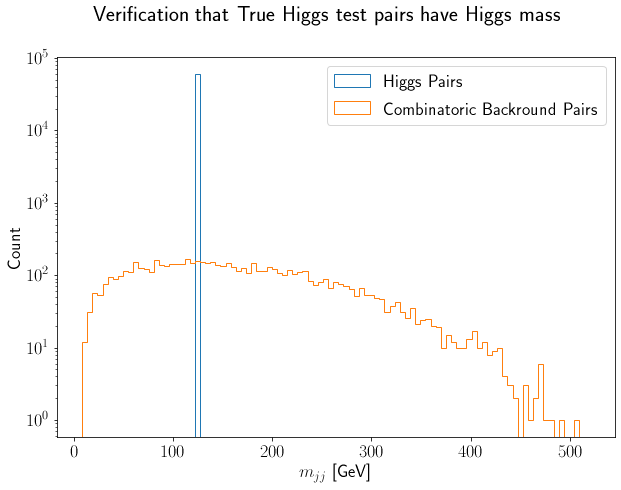

In [17]:
fig, ax = plt.subplots()
fig.suptitle("Verification that True Higgs test pairs have Higgs mass")

bins = np.linspace(np.min(mjj),  np.max(mjj), 100)
n, bins, _ = ax.hist(m_test[y_test == 1], histtype='step', align='mid', bins=bins, label='Higgs Pairs')
ax.hist(m_test[y_test==0], histtype='step', align='mid', bins=bins, label='Combinatoric Backround Pairs')
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'$m_{jj}$ [GeV]')
ax.legend()

plt.show()

# Define Model

In [18]:
# define the keras model
model = Sequential()

# Input layers
model.add(Dense(input_nodes, input_dim=param_dim, activation=input_activation))#, 
#           kernel_initializer=keras.initializers.RandomNormal(seed=20),
#           bias_initializer=keras.initializers.Constant(value=0.1)))

# Hidden layers
for i in range(num_hidden):
    model.add(Dense(nodes[i], activation=hidden_activations[i]))#, 
#           kernel_initializer=keras.initializers.RandomNormal(seed=20),
#           bias_initializer=keras.initializers.Constant(value=0.1)))

# Output layer
model.add(Dense(output_nodes, activation=output_activation))#, 
#           kernel_initializer=keras.initializers.RandomNormal(seed=20),
#           bias_initializer=keras.initializers.Constant(value=0.1)))

W0121 22:08:33.996217 140552237954880 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0121 22:08:34.017662 140552237954880 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0121 22:08:34.022228 140552237954880 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0121 22:08:34.046476 140552237954880 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64

In [19]:
# modify and compile the keras model
optimizer = keras.optimizers.Nadam()

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

lr_metric = get_lr_metric(optimizer)

es = EarlyStopping(monitor='loss', restore_best_weights=True)

model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy', lr_metric])

W0121 22:08:34.277928 140552237954880 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0121 22:08:34.286172 140552237954880 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.



# Train Model

In [20]:
# fit the keras model on the dataset
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                    epochs=num_epochs, batch_size=batch_size, callbacks=[es])

W0121 22:08:34.765071 140552237954880 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 233332 samples, validate on 33334 samples
Epoch 1/100
233332/233332 [==============================] - 19s 81us/step - loss: 0.2875 - acc: 0.9125 - lr: 0.0020 - val_loss: 0.2361 - val_acc: 0.9313 - val_lr: 0.0020
Epoch 2/100
233332/233332 [==============================] - 17s 75us/step - loss: 0.2446 - acc: 0.9295 - lr: 0.0020 - val_loss: 0.2314 - val_acc: 0.9357 - val_lr: 0.0020
Epoch 3/100
233332/233332 [==============================] - 17s 74us/step - loss: 0.2359 - acc: 0.9325 - lr: 0.0020 - val_loss: 0.2386 - val_acc: 0.9317 - val_lr: 0.0020
Epoch 4/100
233332/233332 [==============================] - 17s 74us/step - loss: 0.2375 - acc: 0.9314 - lr: 0.0020 - val_loss: 0.2408 - val_acc: 0.9314 - val_lr: 0.0020


In [21]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
__________

In [22]:
# Get training and test accuracy histories
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

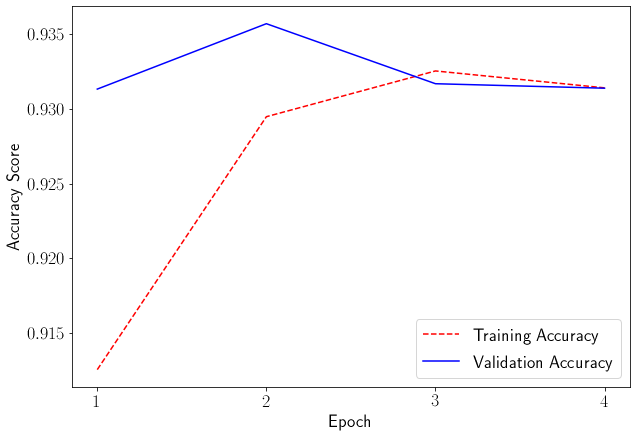

In [23]:
epoch_count = range(1, len(training_accuracy) + 1)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.xticks(epoch_count)
plt.show()

## Save Model

In [24]:
# model_json = model.to_json()
# with open(filesave + ".json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights(filesave + ".h5")
# print("Saved model to disk")

# Performance Evalution

In [25]:
y_pred_test = np.ravel(model.predict(x_test))

In [26]:
# evaluate the keras model
# model.evalute returns the loss and any metric values passed during compilation
loss, accuracy, learning_rate = model.evaluate(x_test, y_pred_test)

66667/66667 [==============================] - 2s 37us/step


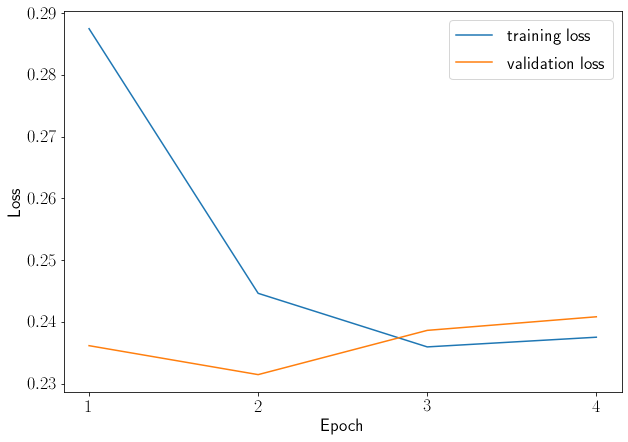

In [27]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, label='training loss')
plt.plot(epoch_count, validation_loss, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_count)
plt.legend()
plt.show()

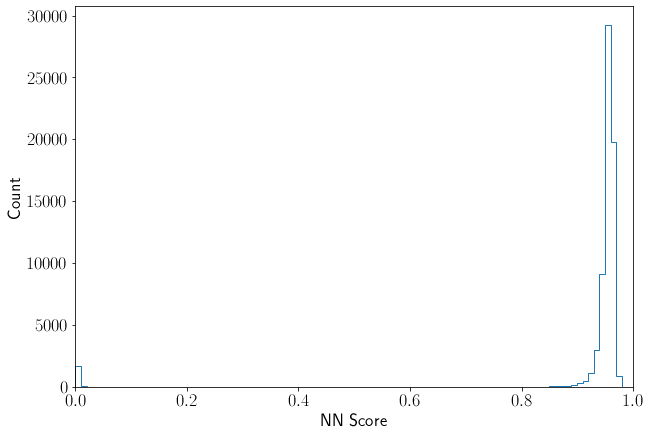

In [28]:
pred_bins = np.linspace(0,1,100)

fig, ax = plt.subplots()
# fig.suptitle("Distribution of NN output for test set")
n, pred_bins, _ = ax.hist(y_pred_test, histtype='step', align='mid', bins=pred_bins)
# plt.yscale('log')
plt.ylabel('Count')
plt.xlabel(r'NN Score')
plt.xlim(0,1)
plt.show()

fig.savefig(plots + "discriminator_distribution.pdf")

In [29]:
true_Higgs_test_mask = (y_test == 1)

true_Higgs_pred = y_pred_test[true_Higgs_test_mask]
true_non_Higgs_pred = y_pred_test[~true_Higgs_test_mask]

non_Higgs_test_m = m_test[~true_Higgs_test_mask]
Higgs_test_m = m_test[true_Higgs_test_mask]

In [30]:
true_positives = np.array(())
true_negatives = np.array(())
false_positives = np.array(())
false_negatives = np.array(())

cuts = np.linspace(0,1,100)
for cut in cuts:
    true_positives = np.append(true_positives, np.sum((y_test == 1) & (y_pred_test > cut))/len(y_test))
    true_negatives = np.append(true_negatives, np.sum((y_test == 0) & (y_pred_test < cut))/len(y_test))
    false_positives = np.append(false_positives, np.sum((y_test == 0) & (y_pred_test > cut))/len(y_test))
    false_negatives = np.append(false_negatives, np.sum((y_test == 1) & (y_pred_test < cut))/len(y_test))

In [31]:
sensitivity = true_positives / (false_positives + true_positives)
specificity = true_negatives / (true_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

# Accuracy

In [32]:
acc = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

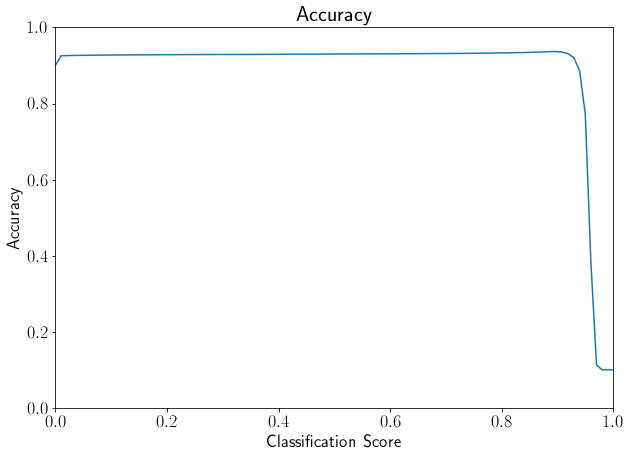

In [33]:
fig = plt.figure(1)
plt.title('Accuracy')
plt.plot(cuts, acc)
plt.xlabel('Classification Score')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.xlim(0,1)

# fig1.savefig(plots + "ROC_curve.pdf")

plt.show()

## F1 Curve

In [34]:
f1_score = 2*1/(1/precision + 1/recall)

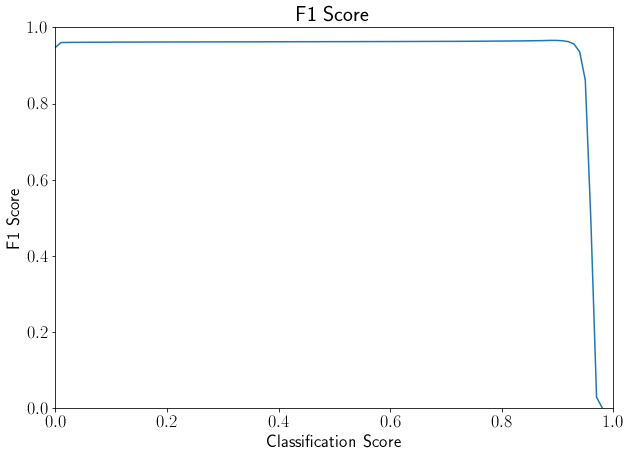

In [35]:
fig = plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
plt.title('F1 Score')
plt.plot(cuts, f1_score)
plt.xlabel('Classification Score')
plt.ylabel('F1 Score')
plt.ylim(0,1)
plt.xlim(0,1)
# plt.title('ROC curve')
# plt.legend(loc='best')

# fig1.savefig(plots + "ROC_curve.pdf")

plt.show()

## ROC Curve 

In [36]:
fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred_test)
nn_auc = auc(fpr, tpr)

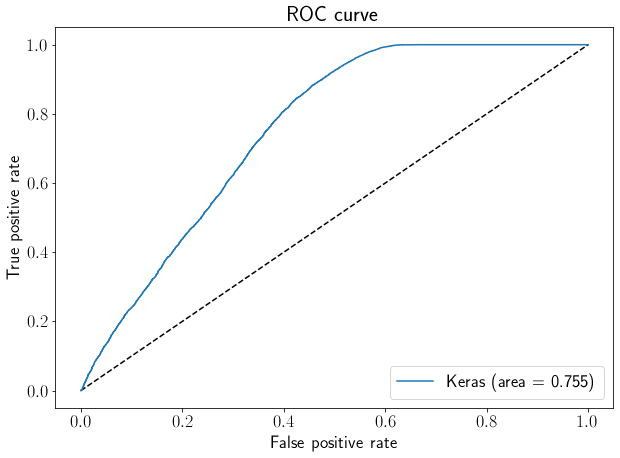

In [37]:
fig1 = plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(nn_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=4)

fig1.savefig(plots + "ROC_curve.pdf")

plt.show()

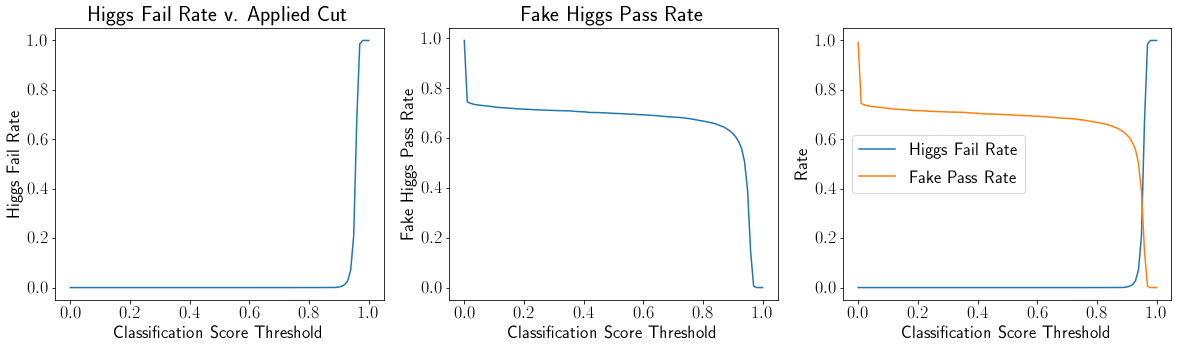

In [38]:
total = len(Higgs_test_m)
mislabelled_Higgs = np.array(())

cuts = np.linspace(0,1,100)
for cut in cuts:
    mislabelled_Higgs = np.append(mislabelled_Higgs, len(Higgs_test_m[true_Higgs_pred < cut]))
mislabelled_Higgs = mislabelled_Higgs / total

fig3, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

ax = axs[0]
ax.set_title("Higgs Fail Rate v. Applied Cut")
ax.plot(cuts, mislabelled_Higgs)
ax.set_ylabel('Higgs Fail Rate')
ax.set_xlabel(r'Classification Score Threshold')

total = len(non_Higgs_test_m)
fake_Higgs = np.array(())

cuts = np.linspace(0,1,100)
for cut in cuts:
    fake_Higgs = np.append(fake_Higgs, len(non_Higgs_test_m[true_non_Higgs_pred > cut]))
    
fake_Higgs = fake_Higgs / total

ax = axs[1]
ax.set_title("Fake Higgs Pass Rate")
ax.plot(cuts, fake_Higgs)
ax.set_ylabel('Fake Higgs Pass Rate')
ax.set_xlabel(r'Classification Score Threshold')

ax = axs[2]
ax.plot(cuts, mislabelled_Higgs, label='Higgs Fail Rate')
ax.plot(cuts, fake_Higgs, label='Fake Pass Rate')
ax.set_ylabel('Rate')
ax.set_xlabel(r'Classification Score Threshold')
ax.legend()

plt.show()

fig3.savefig(plots + "pass_fail_rate.pdf")

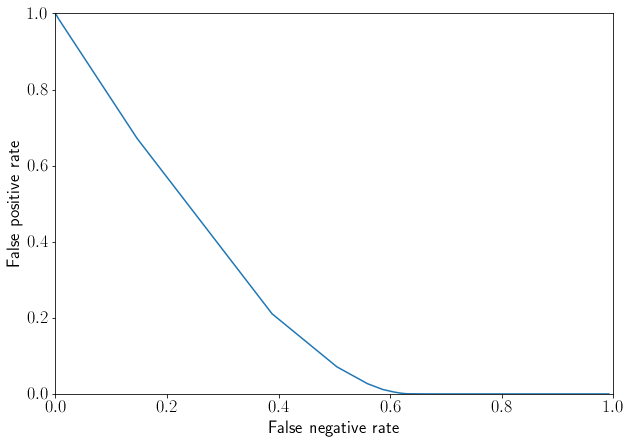

In [39]:
fig = plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fake_Higgs, mislabelled_Higgs)
plt.xlabel('False negative rate')
plt.ylabel('False positive rate')
plt.xlim(0,1)
plt.ylim(0,1)
# plt.title('ROC curve')

# fig1.savefig(plots + "ROC_curve.pdf")

plt.show()

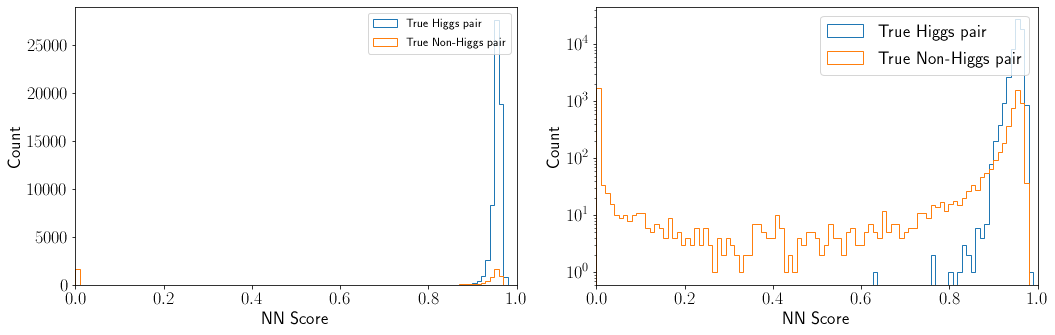

In [40]:
fig2, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
# fig.suptitle("Distribution of NN output for test set")

ax = axs[0]
ax.hist(true_Higgs_pred, histtype='step', align='mid', bins=pred_bins, label='True Higgs pair')
ax.hist(true_non_Higgs_pred, histtype='step', align='mid', bins=pred_bins, label='True Non-Higgs pair')
# plt.yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'NN Score')
ax.set_xlim(0,1)
ax.legend(fontsize=12)

ax = axs[1]
ax.hist(true_Higgs_pred, histtype='step', align='mid', bins=pred_bins, label='True Higgs pair')
ax.hist(true_non_Higgs_pred, histtype='step', align='mid', bins=pred_bins, label='True Non-Higgs pair')
plt.yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'NN Score')
ax.set_xlim(0,1)
ax.legend()

plt.tight_layout()
plt.show()

fig2.savefig(plots + "discriminator_distribution_true_v_false.pdf")

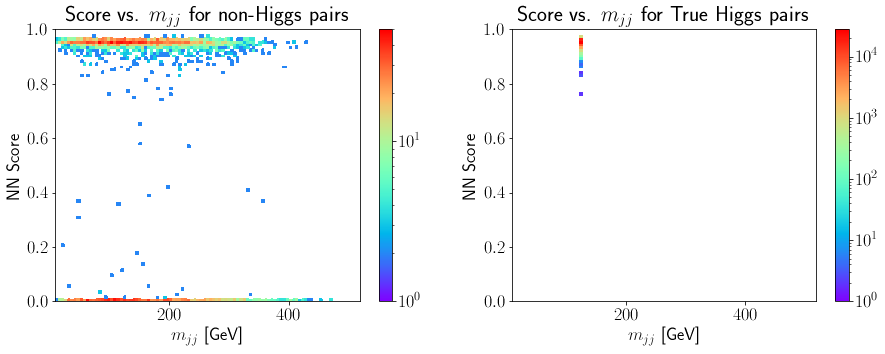

In [41]:
mass_bins = np.linspace(np.min(mjj), np.max(mjj), 100)

fig4, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax = axs[0]
ax.set_title(r"Score vs. $m_{jj}$ for non-Higgs pairs")
n, bx, by, im = ax.hist2d(non_Higgs_test_m, true_non_Higgs_pred, bins=[mass_bins,pred_bins], norm=colors.LogNorm(), cmap=cmap)
ax.set_xlabel(r'$m_{jj}$  [GeV]')
ax.set_ylabel(r'NN Score')
fig.colorbar(im, ax=ax)
plt.savefig(plots + "score_v_nonHiggs_mjj.pdf")

ax = axs[1]
ax.set_title(r"Score vs. $m_{jj}$ for True Higgs pairs")
n, bx, by, im = ax.hist2d(Higgs_test_m, true_Higgs_pred, bins=[mass_bins,pred_bins], norm=colors.LogNorm(), cmap=cmap)
ax.set_xlabel(r'$m_{jj}$  [GeV]')
ax.set_ylabel(r'NN Score')
fig.colorbar(im, ax=ax)
plt.savefig(plots + "score_v_mbb.pdf")
plt.show()

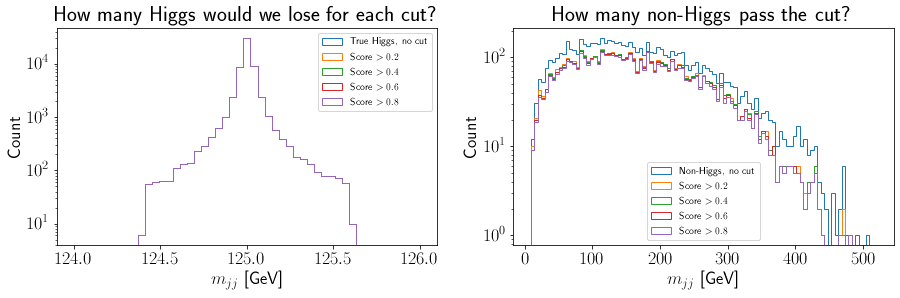

In [42]:
nn_score_cuts = [0.2, 0.4, 0.6, 0.8]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

ax = axs[0]
ax.set_title("How many Higgs would we lose for each cut?")
n, b, _ = ax.hist(Higgs_test_m, histtype='step', align='mid', bins=np.linspace(124,126,50), label='True Higgs, no cut')
ax.hist(Higgs_test_m[true_Higgs_pred > 0.2], histtype='step', align='mid', bins=b, label=r'Score $> 0.2$')
ax.hist(Higgs_test_m[true_Higgs_pred > 0.4], histtype='step', align='mid', bins=b, label=r'Score $> 0.4$')
ax.hist(Higgs_test_m[true_Higgs_pred > 0.6], histtype='step', align='mid', bins=b, label=r'Score $> 0.6$')
ax.hist(Higgs_test_m[true_Higgs_pred > 0.8], histtype='step', align='mid', bins=b, label=r'Score $> 0.8$')
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'$m_{jj}$ [GeV]')
ax.legend(fontsize=10)

ax = axs[1]
ax.set_title("How many non-Higgs pass the cut?")
ax.hist(non_Higgs_test_m, histtype='step', align='mid', bins=bins, label='Non-Higgs, no cut')
ax.hist(non_Higgs_test_m[true_non_Higgs_pred > 0.2], histtype='step', align='mid', bins=bins, label=r'Score $> 0.2$')
ax.hist(non_Higgs_test_m[true_non_Higgs_pred > 0.4], histtype='step', align='mid', bins=bins, label=r'Score $> 0.4$')
ax.hist(non_Higgs_test_m[true_non_Higgs_pred > 0.6], histtype='step', align='mid', bins=bins, label=r'Score $> 0.6$')
ax.hist(non_Higgs_test_m[true_non_Higgs_pred > 0.8], histtype='step', align='mid', bins=bins, label=r'Score $> 0.8$')
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel(r'$m_{jj}$ [GeV]')
ax.legend(fontsize=10, loc=8)

plt.show()

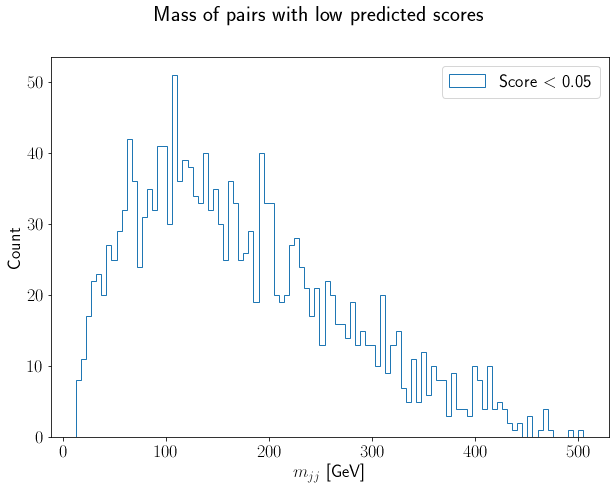

In [43]:
fig, ax = plt.subplots()
fig.suptitle("Mass of pairs with low predicted scores")
ax.hist(m_test[y_pred_test < 0.05], bins=100, label=r'Score $<$ 0.05', histtype='step', align='mid')
plt.ylabel('Count')
plt.xlabel(r'$m_{jj}$  [GeV]')
plt.legend()
plt.show()

In [44]:
deltaR = calculate_deltaR(X_test[:,1], X_test[:,4], X_test[:,2], X_test[:,5])

non_Higgs_pred = y_pred_test[~true_Higgs_test_mask]
non_Higgs_deltaR = deltaR[~true_Higgs_test_mask]

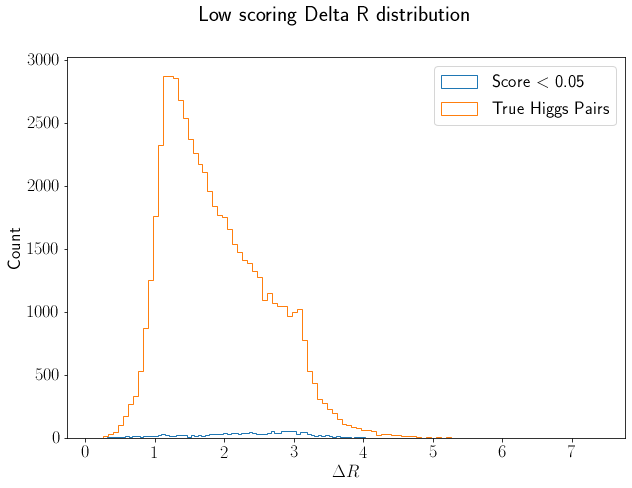

In [45]:
fig, ax = plt.subplots()
fig.suptitle("Low scoring Delta R distribution")
ax.hist(deltaR[y_pred_test < 0.05], bins=100, label=r'Score $<$ 0.05', histtype='step', align='mid')
ax.hist(deltaR[true_Higgs_test_mask], bins=100, histtype='step', align='mid', label='True Higgs Pairs')
plt.ylabel('Count')
plt.xlabel(r'$\Delta R$')
plt.legend()
plt.show()

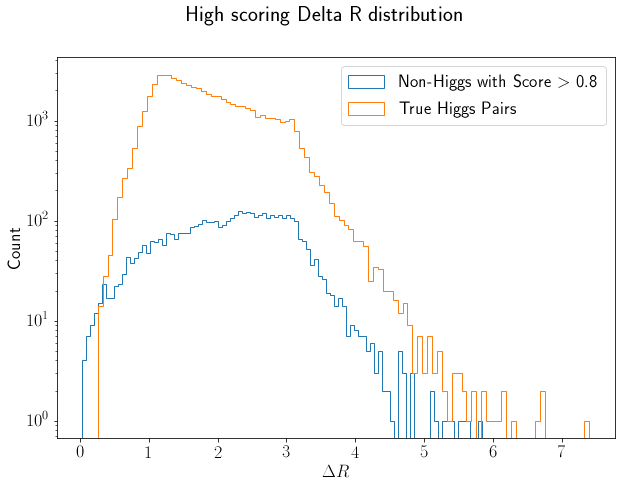

In [46]:
fig, ax = plt.subplots()
fig.suptitle("High scoring Delta R distribution")
ax.hist(non_Higgs_deltaR[non_Higgs_pred > 0.8], bins=100, label=r'Non-Higgs with Score $>$ 0.8', histtype='step', align='mid')
ax.hist(deltaR[true_Higgs_test_mask], bins=100, histtype='step', align='mid', label='True Higgs Pairs')
plt.ylabel('Count')
plt.xlabel(r'$\Delta R$')
plt.yscale('log')
plt.legend()
plt.show()

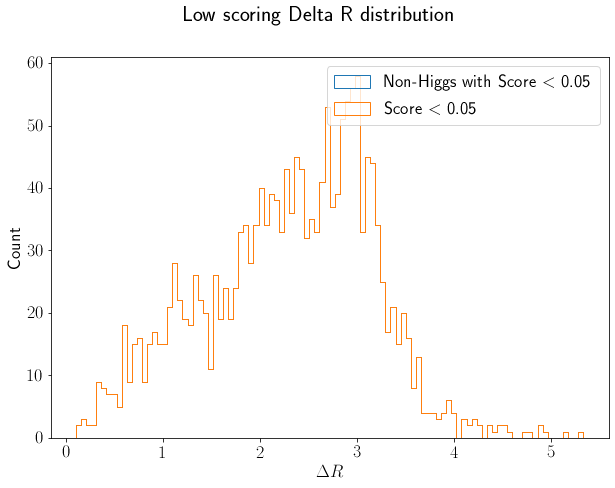

In [47]:
fig, ax = plt.subplots()
fig.suptitle("Low scoring Delta R distribution")
ax.hist(non_Higgs_deltaR[non_Higgs_pred < 0.05], bins=100, label=r'Non-Higgs with Score $<$ 0.05', histtype='step', align='mid')
ax.hist(deltaR[y_pred_test < 0.05], bins=100, label=r'Score $<$ 0.05', histtype='step', align='mid')
plt.ylabel('Count')
plt.xlabel(r'$\Delta R$')
plt.legend()
plt.show()

In [48]:
len(non_Higgs_deltaR[(abs(non_Higgs_test_m-125) < 0.6)])

42

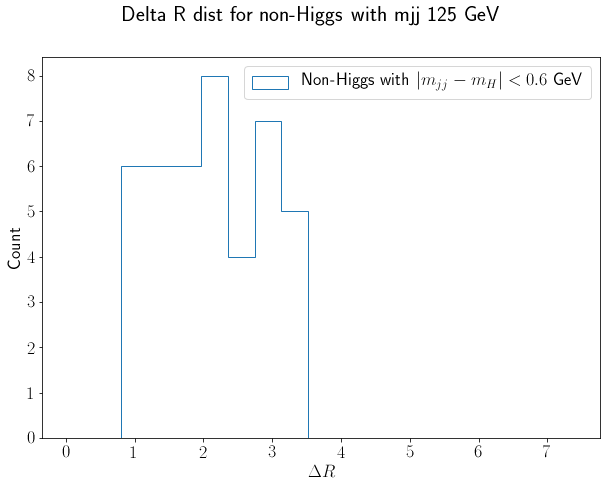

In [49]:
non_Higgs_mass = m_test[~true_Higgs_test_mask]
dR_bins = np.linspace(np.min(deltaR), np.max(deltaR), 20)

fig, ax = plt.subplots()
fig.suptitle("Delta R dist for non-Higgs with mjj~125 GeV")
ax.hist(non_Higgs_deltaR[(abs(non_Higgs_mass-125) < 0.6)], bins=dR_bins, label=r'Non-Higgs with $|m_{jj}-m_H|<0.6$ GeV', histtype='step', align='mid')
plt.ylabel('Count')
plt.xlabel(r'$\Delta R$')
plt.legend()
plt.show()

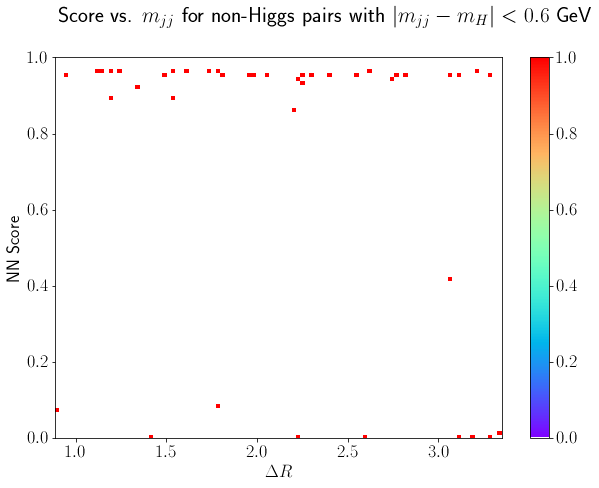

In [50]:
non_Higgs_deltaR[(abs(non_Higgs_mass-125) < 0.6)]
                 
fig, ax = plt.subplots()
fig.suptitle(r"Score vs. $m_{jj}$ for non-Higgs pairs with $|m_{jj} - m_H|   < 0.6$ GeV")
n, bx, by, im = ax.hist2d(non_Higgs_deltaR[(abs(non_Higgs_mass-125) < 0.6)], y_pred_test[~true_Higgs_test_mask][(abs(non_Higgs_mass-125) < 0.6)], bins=[100,pred_bins], cmap=cmap)
ax.set_xlabel(r'$\Delta R$')
ax.set_ylabel(r'NN Score')
ax.set_ylim(0,1)
fig.colorbar(im, ax=ax)
# plt.savefig("score_v_nonHiggs_mjj.pdf")
plt.show()

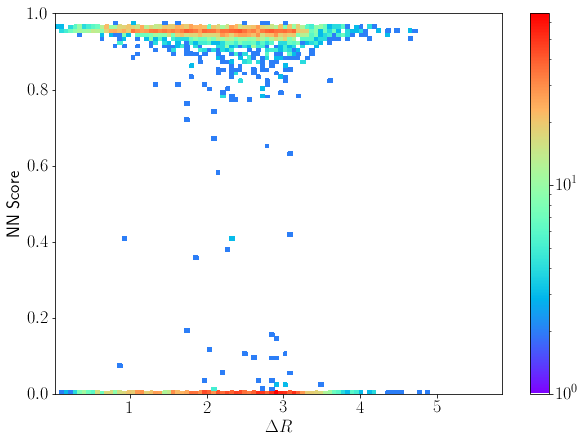

In [51]:
fig, ax = plt.subplots()
# fig.suptitle(r"Score vs. $m_{jj}$ for non-Higgs pairs")
n, bx, by, im = ax.hist2d(deltaR[~true_Higgs_test_mask], y_pred_test[~true_Higgs_test_mask], bins=[100,pred_bins], norm=colors.LogNorm(), cmap=cmap)
ax.set_xlabel(r'$\Delta R$')
ax.set_ylabel(r'NN Score')
fig.colorbar(im, ax=ax)
ax.set_ylim(0,1)
# plt.savefig("score_v_nonHiggs_mjj.pdf")
plt.show()

In [52]:
h_act = ''
for funcs in hidden_activations:
    h_act = h_act + funcs + ', '

print("Training set:                {:d}%".format(int(len(x_train)/len(X)*100)))
print("Validation set:              {:d}%".format(int(len(x_val)/len(X)*100)))
print("Testing set:                 {:d}%".format(int(len(x_test)/len(X)*100)))
print("Sucesses:                    {:.0f}%".format(successes*100))
print("Failures:                    {:.0f}%".format(fails*100))
print("Input parameters:           ", param_dim)
print("Optimizer:                  ", optimizer)
print("Loss:                       ", loss_function)
print("Num epochs:                 ", num_epochs)
print("Batch size:                 ", batch_size)
print("Num input nodes:            ", input_nodes)
print("Input activation function:  ", input_activation)
print("Num hidden layers:          ", num_hidden)
print("Hidden layer nodes:         ", nodes)
print("Hidden activation functions:", h_act[:-2])
print("Num output nodes:           ", output_nodes)
print("Output activation function: ", output_activation)

Training set:                38%
Validation set:              5%
Testing set:                 11%
Sucesses:                    90%
Failures:                    10%
Input parameters:            7
Optimizer:                   <keras.optimizers.Nadam object at 0x7fd4b8391fd0>
Loss:                        binary_crossentropy
Num epochs:                  100
Batch size:                  250
Num input nodes:             7
Input activation function:   selu
Num hidden layers:           8
Hidden layer nodes:          [32, 64, 64, 128, 128, 64, 64, 32]
Hidden activation functions: selu, selu, selu, selu, selu, selu, selu, selu
Num output nodes:            1
Output activation function:  sigmoid


In [53]:
# with PdfPages(plots + 'classifier_analysis.pdf') as pdf:

#     ######################################

# #     fig, axs = plt.subplots(nrows=2,ncols=1)

# #     ax = axs[0]
# #     ax.axis('tight')
# #     ax.axis('off')
# #     the_table = ax.table(cellText=nn_structure.values, rowLabels=nn_structure.index,loc='center', edges='vertical')

# #     ax = axs[1]
# #     ax.axis('tight')
# #     ax.axis('off')
# #     # plotting.table(ax, nn_architecture)
# #     the_table = ax.table(cellText=nn_architecture.values, rowLabels=nn_architecture.index,loc='center', edges='vertical', cellLoc='center')

# #     # plt.tight_layout()
# #     plt.subplots_adjust(top=0.97, bottom=0.08, left=0.5, right=0.9, hspace=0.10, wspace=0.20)

# #     pdf.savefig()  # saves the current figure into a pdf page
# #     plt.close()

# #     #########################################

#     Higgs_mask = exp_y == 1
#     fig, ax = plt.subplots(nrows=1, ncols=1)
#     fig.suptitle("Verification that True Higgs pairs have Higgs mass")

#     bins = np.linspace(np.min(mjj),  np.max(mjj), 100)
#     n, bins, _ = ax.hist(exp_mjj[Higgs_mask], histtype='step', align='mid', bins=bins, label='Higgs Pairs')
#     ax.hist(exp_mjj[~Higgs_mask], histtype='step', align='mid', bins=bins, label='Combinatoric Backround Pairs')
#     ax.set_yscale('log')
#     ax.set_ylabel('Count')
#     ax.set_xlabel(r'$m_{jj}$ [GeV]')
#     ax.legend()

#     pdf.savefig()  # saves the current figure into a pdf page
#     plt.close()

#     #####################################

#     # fig = plt.figure()
#     epoch_count = range(1, len(training_accuracy) + 1)
#     plt.plot(epoch_count, training_accuracy, 'r--')
#     plt.plot(epoch_count, validation_accuracy, 'b-')
#     plt.legend(['Training Accuracy', 'Validation Accuracy'], loc=4)
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy Score')

#     pdf.savefig()
#     plt.close()

    
#     #########################################

#     fig = plt.figure(1)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#     plt.xlabel('False positive rate')
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve')
#     plt.legend(loc='best')
#     # plt.plot([0.1,0.1],[0,1], '--')

#     pdf.savefig(fig)  # or you can pass a Figure object to pdf.savefig
#     plt.close()


#     #########################################


#     fig, ax = plt.subplots()
#     fig.suptitle("Distribution of NN output for test set")
#     n, bins, _ = ax.hist(y_pred_test, histtype='step', align='mid', bins=50)
#     # plt.yscale('log')
#     plt.ylabel('Count')
#     plt.xlabel(r'NN Score')
#     plt.xlim(0,1)
#     plt.legend()

#     pdf.savefig()
#     plt.close()

#     #####################################



#     fig, ax = plt.subplots()
#     fig.suptitle("Distribution of NN output for test set")
#     ax.hist(y_pred_test[Higgs_test_mask], histtype='step', align='mid', bins=bins, label='True Higgs pair')
#     ax.hist(y_pred_test[~Higgs_test_mask], histtype='step', align='mid', bins=bins, label='True Non-Higgs pair')
#     # plt.yscale('log')
#     plt.ylabel('Count')
#     plt.xlabel(r'NN Score')
#     plt.xlim(0,1)
#     plt.legend()

#     pdf.savefig()
#     plt.close()

#     #####################################

#     fig, ax = plt.subplots()
#     fig.suptitle(r"Score vs. $m_{jj}$ for non-Higgs pairs")
#     n, bx, by, im = ax.hist2d(m_test[~Higgs_test_mask], y_pred_test[~Higgs_test_mask], bins=[100,np.linspace(0,1,50)], norm=colors.LogNorm(), cmap=cmap)
#     ax.set_xlabel(r'$m_{jj}$  [GeV]')
#     ax.set_ylabel(r'NN Score')
#     fig.colorbar(im, ax=ax)

#     pdf.savefig()
#     plt.close()


In [54]:
with PdfPages(plots + 'classifier_analysis.pdf') as pdf:

    fig = fig1

    pdf.savefig(fig)  # saves the current figure into a pdf page
    plt.close()
    
    
    fig = fig2

    pdf.savefig(fig)  # saves the current figure into a pdf page
    plt.close()
    
    
    fig = fig3

    pdf.savefig(fig)  # saves the current figure into a pdf page
    plt.close()
    
    fig = fig4

    pdf.savefig(fig)  # saves the current figure into a pdf page
    plt.close()
    